In [1]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu
from importlib import reload
reload(dp)
reload(iu)

import os
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


Tensorflow version: 2.1.0
Tensorflow version: 2.1.0


In [2]:
dp.test()
iu.test()

Testing data processing.
Testing improved unet.


In [3]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = dataset_path + "keras_png_slices_seg_test/"
seg_train_path = dataset_path + "keras_png_slices_seg_train/"
seg_val_path = dataset_path + "keras_png_slices_seg_validate/"
test_path = dataset_path + "keras_png_slices_test/"
train_path = dataset_path + "keras_png_slices_train/"
val_path = dataset_path + "keras_png_slices_validate/"

In [4]:
# Load images
reload(dp)
seg_test = dp.load_image(seg_test_path)
seg_train = dp.load_image(seg_train_path)
seg_val = dp.load_image(seg_val_path)
test = dp.load_image(test_path)
train = dp.load_image(train_path)
val = dp.load_image(val_path)

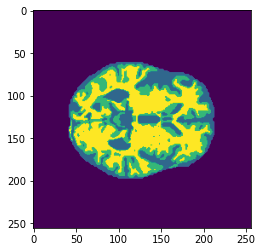

In [5]:
plt.imshow(seg_train[0])

In [6]:
# One hot encode labels
seg_test = dp.one_hot_encode(seg_test)

In [7]:
seg_train = dp.one_hot_encode(seg_train)

In [8]:
seg_val = dp.one_hot_encode(seg_val)

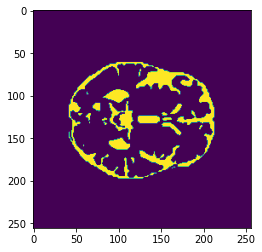

In [9]:
plt.imshow(seg_train[0][:,:,2])

In [10]:
print(np.array(train).shape)
print(np.array(seg_train).shape)

(200, 256, 256, 1)
(200, 256, 256, 4)


In [11]:
reload(iu)
# Generate improved unet model
model = iu.unet()

Tensorflow version: 2.1.0
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        leaky_re_lu_1[0][0]              
__________________________________________________________________

In [12]:
# Compile the model
reload(iu)
model.compile(optimizer='adam', 
              loss='binary_crossentropy', metrics=[iu.dice_coefficient_avg])

# model.compile(optimizer='adam', 
#               loss=iu.dice_loss, metrics=[iu.dice_coefficient_avg])

Tensorflow version: 2.1.0


In [13]:
# Train the model
history = model.fit(np.array(train), np.array(seg_train), 
                    batch_size=32, epochs=200, 
                    validation_data=(np.array(val), np.array(seg_val)))

Train on 200 samples, validate on 200 samples
Epoch 1/200
200/200 [==============================] - 9s 44ms/step - loss: 0.5604 - dice_coefficient_avg: 0.2544 - val_loss: 0.5434 - val_dice_coefficient_avg: 0.2657
Epoch 2/200
200/200 [==============================] - 2s 11ms/step - loss: 0.5426 - dice_coefficient_avg: 0.2682 - val_loss: 0.5190 - val_dice_coefficient_avg: 0.2998
Epoch 3/200
200/200 [==============================] - 2s 11ms/step - loss: 0.5281 - dice_coefficient_avg: 0.2919 - val_loss: 0.5197 - val_dice_coefficient_avg: 0.2890
Epoch 4/200
200/200 [==============================] - 2s 11ms/step - loss: 0.5172 - dice_coefficient_avg: 0.2978 - val_loss: 0.5056 - val_dice_coefficient_avg: 0.3113
Epoch 5/200
200/200 [==============================] - 2s 12ms/step - loss: 0.5059 - dice_coefficient_avg: 0.3139 - val_loss: 0.4963 - val_dice_coefficient_avg: 0.3215
Epoch 6/200
200/200 [==============================] - 2s 12ms/step - loss: 0.4946 - dice_coefficient_avg: 0.3239 

200/200 [==============================] - 2s 12ms/step - loss: 0.1200 - dice_coefficient_avg: 0.8403 - val_loss: 0.1199 - val_dice_coefficient_avg: 0.8402
Epoch 50/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1199 - dice_coefficient_avg: 0.8395 - val_loss: 0.1181 - val_dice_coefficient_avg: 0.8414
Epoch 51/200
200/200 [==============================] - 2s 11ms/step - loss: 0.1192 - dice_coefficient_avg: 0.8423 - val_loss: 0.1203 - val_dice_coefficient_avg: 0.8445
Epoch 52/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1207 - dice_coefficient_avg: 0.8407 - val_loss: 0.1221 - val_dice_coefficient_avg: 0.8346
Epoch 53/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1204 - dice_coefficient_avg: 0.8404 - val_loss: 0.1202 - val_dice_coefficient_avg: 0.8380
Epoch 54/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1199 - dice_coefficient_avg: 0.8396 - val_loss: 0.1182 - val_dice_coefficient_avg: 0.8436

200/200 [==============================] - 2s 12ms/step - loss: 0.1051 - dice_coefficient_avg: 0.8608 - val_loss: 0.1248 - val_dice_coefficient_avg: 0.8450
Epoch 98/200
200/200 [==============================] - 2s 11ms/step - loss: 0.1056 - dice_coefficient_avg: 0.8601 - val_loss: 0.1266 - val_dice_coefficient_avg: 0.8506
Epoch 99/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1050 - dice_coefficient_avg: 0.8617 - val_loss: 0.1237 - val_dice_coefficient_avg: 0.8497
Epoch 100/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1032 - dice_coefficient_avg: 0.8644 - val_loss: 0.1233 - val_dice_coefficient_avg: 0.8506
Epoch 101/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1028 - dice_coefficient_avg: 0.8653 - val_loss: 0.1232 - val_dice_coefficient_avg: 0.8498
Epoch 102/200
200/200 [==============================] - 2s 12ms/step - loss: 0.1019 - dice_coefficient_avg: 0.8666 - val_loss: 0.1244 - val_dice_coefficient_avg: 0.8

200/200 [==============================] - 2s 12ms/step - loss: 0.0821 - dice_coefficient_avg: 0.8935 - val_loss: 0.1487 - val_dice_coefficient_avg: 0.8545
Epoch 146/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0815 - dice_coefficient_avg: 0.8944 - val_loss: 0.1523 - val_dice_coefficient_avg: 0.8557
Epoch 147/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0815 - dice_coefficient_avg: 0.8952 - val_loss: 0.1479 - val_dice_coefficient_avg: 0.8545
Epoch 148/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0811 - dice_coefficient_avg: 0.8947 - val_loss: 0.1551 - val_dice_coefficient_avg: 0.8503
Epoch 149/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0809 - dice_coefficient_avg: 0.8954 - val_loss: 0.1491 - val_dice_coefficient_avg: 0.8541
Epoch 150/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0802 - dice_coefficient_avg: 0.8957 - val_loss: 0.1497 - val_dice_coefficient_avg: 0

200/200 [==============================] - 2s 12ms/step - loss: 0.0676 - dice_coefficient_avg: 0.9131 - val_loss: 0.1728 - val_dice_coefficient_avg: 0.8572
Epoch 194/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0674 - dice_coefficient_avg: 0.9138 - val_loss: 0.1716 - val_dice_coefficient_avg: 0.8561
Epoch 195/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0670 - dice_coefficient_avg: 0.9140 - val_loss: 0.1738 - val_dice_coefficient_avg: 0.8570
Epoch 196/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0667 - dice_coefficient_avg: 0.9144 - val_loss: 0.1723 - val_dice_coefficient_avg: 0.8550
Epoch 197/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0664 - dice_coefficient_avg: 0.9145 - val_loss: 0.1756 - val_dice_coefficient_avg: 0.8560
Epoch 198/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0659 - dice_coefficient_avg: 0.9162 - val_loss: 0.1761 - val_dice_coefficient_avg: 0

In [14]:
test_loss, test_acc = model.evaluate(np.array(test), np.array(seg_test), verbose=2)
print(test_acc)

0.854701817035675


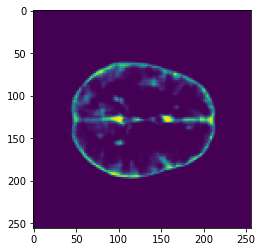

In [19]:
prediction = model.predict(np.array(test))
plt.imshow(prediction[3][:,:,2])

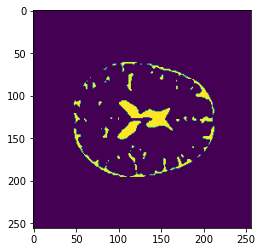

In [20]:
plt.imshow(seg_test[3][:,:,2])

In [17]:
reload(iu)
print(iu.dice_loss(np.array(seg_test), np.array(prediction)))
print(iu.dice_coefficient(np.array(seg_test), np.array(prediction)))

Tensorflow version: 2.1.0
tf.Tensor(0.14514565, shape=(), dtype=float32)
tf.Tensor(
[0.8213097  0.8573298  0.8510412  0.8613772  0.84983015 0.85296184
 0.87044084 0.8615097  0.86095667 0.8551484  0.8511055  0.86421615
 0.8591972  0.859485   0.8691953  0.86253905 0.86038494 0.8334722
 0.8655262  0.865188   0.8355607  0.8516441  0.8444398  0.83863324
 0.8730796  0.8338166  0.8380855  0.8515258  0.8800376  0.85848606
 0.83755565 0.8703889  0.8551347  0.86581296 0.8733683  0.85996366
 0.83815235 0.86231023 0.8572928  0.856577   0.8562685  0.8701729
 0.8258717  0.84244776 0.85441846 0.8483723  0.84557337 0.84736526
 0.8522582  0.8755559  0.86226726 0.8617466  0.8571982  0.8376225
 0.8551029  0.84819275 0.871207   0.86699575 0.8508441  0.8481497
 0.85842586 0.8503449  0.8543101  0.86444354 0.8588029  0.855072
 0.87302285 0.83631223 0.86480457 0.8637423  0.84753203 0.8773498
 0.8582086  0.8522503  0.8808698  0.87717223 0.8414626  0.8633448
 0.8399181  0.8495005  0.8657045  0.84599024 0.863957